In [51]:
import numpy as np
from sklearn.model_selection import KFold

def gen_data(n_samples, dim_x, dim_z, kappa_x, kappa_theta, sigma_eta, sigma_epsilon):
    """ Generate data from:
    y = <z[support_theta], theta> * t + <x[support_x], alpha_x> + epsilon
    t = <x[support_x], beta_x> + eta
    epsilon ~ Normal(0, sigma_epsilon)
    eta ~ Normal(0, sigma_eta)
    z = (x[subset_z], 1) for some subset of x of size dim_z - 1
    alpha_x, beta_x, theta are all equal to 1
    support_x, support_theta, subset_z drawn uniformly at random
    """
    x = np.random.normal(0, 1, size=(n_samples, dim_x))
    if dim_z == 1:
        z = np.ones((n_samples, 1))
    else:
        supp_z = np.random.choice(np.arange(x.shape[1]), dim_z-1, replace=False)
        z = np.concatenate((x[:, supp_z].reshape(n_samples, -1), np.ones((n_samples, 1))), axis=1)
        
    support_x = np.random.choice(np.arange(0, dim_x), kappa_x, replace=False)
    support_theta = np.random.choice(np.arange(0, dim_z), kappa_theta, replace=False)
    alpha_x = np.random.uniform(1, 1, size=(kappa_x, 1))
    beta_x = np.random.uniform(1, 1, size=(kappa_x, 1))
    theta = np.random.uniform(1, 1, size=(kappa_theta, 1))
    t = np.dot(x[:, support_x], beta_x) + np.random.normal(0, sigma_eta, size=(n_samples, 1))
    y = np.dot(z[:, support_theta], theta) * t + np.dot(x[:, support_x], alpha_x) + np.random.normal(0, sigma_epsilon, size=(n_samples, 1))
    return x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta


def cross_product(X1, X2):
    """ Cross product of features in matrices X1 and X2
    """
    n = np.shape(X1)[0]
    assert n == np.shape(X2)[0]
    return (X1.reshape(n,1,-1) * X2.reshape(n,-1,1)).reshape(n,-1) 

def dml_fit(x, t, z, y, model_t, model_y, model_f):
    """ Orthogonal estimation of coefficient theta
    """
    n_samples = x.shape[0]
    comp_x = cross_product(z, x)
    
    model_t.fit(x[:n_samples//2], t[:n_samples//2].flatten())
    model_y.fit(comp_x[:n_samples//2], y[:n_samples//2].flatten())
    res_t = t[n_samples//2:] - model_t.predict(x[n_samples//2:]).reshape((n_samples//2, -1))
    res_y = y[n_samples//2:] - model_y.predict(comp_x[n_samples//2:]).reshape((n_samples//2, -1))
    model_f.fit(z[n_samples//2:]*res_t, res_y.flatten())
    return model_f.coef_.flatten(), model_t.coef_.flatten(), model_y.coef_.flatten()

def dml_crossfit(x, t, z, y, model_t, model_y, model_f):
    """ Orthogonal estimation of coefficient theta with cross-fitting
    """
    n_samples = x.shape[0]
    comp_x = cross_product(z, x)
    
    kf = KFold(n_splits=2)
    res_y = np.zeros(y.shape)
    res_t = np.zeros(t.shape)
    for train_index, test_index in kf.split(x):
        model_t.fit(x[train_index], t[train_index].flatten())
        model_y.fit(comp_x[train_index], y[train_index].flatten())
        res_t[test_index] = t[test_index] - model_t.predict(x[test_index]).reshape(test_index.shape[0], -1)
        res_y[test_index] = y[test_index] - model_y.predict(comp_x[test_index]).reshape(test_index.shape[0], -1)
    
    model_f.fit(z*res_t, res_y.flatten())
    return model_f.coef_.flatten(), model_t.coef_.flatten(), model_y.coef_.flatten()

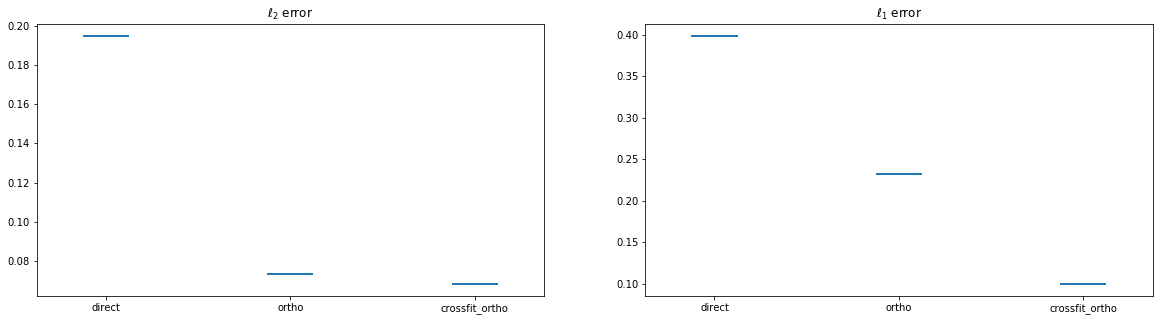

In [61]:
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt

def main():
    n_samples = 2000 # samples used for estimation
    dim_x = 200 # dimension of controls x
    dim_z = 200 # dimension of variables used for heterogeneity (subset of x)
    kappa_x = 5 # support size of control function
    kappa_theta = 2 # support size of target parameter
    sigma_eta = 1 # variance of error in secondary moment equation
    sigma_epsilon = 1 # variance of error in primary moment equation
    lambda_coef = 1 # coeficient in front of the asymptotic rate for regularization lambda

    l2_direct = []
    l2_ortho = []
    l2_cross_ortho = []
    l1_direct = []
    l1_ortho = []
    l1_cross_ortho = []
    for _ in range(1):
        # Generate data
        x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta =\
                gen_data(n_samples, dim_x, dim_z, kappa_x, kappa_theta, sigma_eta, sigma_epsilon)

        true_coef = np.zeros((dim_z,1))
        true_coef[support_theta] = theta

        # Direct lasso for all coefficients
        ols = Lasso(alpha=np.sqrt(np.log(dim_z + dim_x)/n_samples))
        ols.fit(np.concatenate((z*t, x), axis=1), y.flatten())
        l1_direct.append(np.linalg.norm(ols.coef_.flatten()[:dim_z] - true_coef.flatten(), ord=1))
        l2_direct.append(np.linalg.norm(ols.coef_.flatten()[:dim_z] - true_coef.flatten(), ord=2))
        
        # Orthogonal lasso estimation
        ortho_coef, t_coef, y_coef = dml_fit(x, t, z, y,\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z*dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z)*2. / n_samples), fit_intercept=False))
        l1_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=1))
        l2_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=2))
        
        # Crossfit Orthogonal lasso estimation
        ortho_coef, t_coef, y_coef = dml_crossfit(x, t, z, y,\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z*dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z)*2. / n_samples), fit_intercept=False))
        l1_cross_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=1))
        l2_cross_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=2))


    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.violinplot([np.array(l2_direct), np.array(l2_ortho), np.array(l2_cross_ortho)], showmedians=True)
    plt.xticks([1,2,3], ['direct', 'ortho', 'crossfit_ortho'])
    plt.title('$\ell_2$ error')
    plt.subplot(1,2,2)
    plt.violinplot([np.array(l1_direct), np.array(l1_ortho), np.array(l1_cross_ortho)], showmedians=True)
    plt.xticks([1,2,3], ['direct', 'ortho', 'crossfit_ortho'])
    plt.title('$\ell_1$ error')
    plt.show()
    
main()